In [0]:
#importing libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from statistics import mean 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [2]:
#mounting my drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
X1 =  np.load('/content/drive/My Drive/normalized_phase_diff.npy')
X2 = np.load('/content/drive/My Drive/normalized_amplitude_reshaped.npy')
y =  np.load('/content/drive/My Drive/labels.npy')

INPUT_COUNT = X1.shape[1]
X1 = X1 - np.transpose(X1.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X1 = np.absolute(X1)

X2 = X2 - np.transpose(X2.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X2 = np.absolute(X2)

X = np.append(X1, X2, axis=1)

del X1, X2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1999596)

del X, y


INPUT_COUNT = X_test.shape[1]


train = np.append(X_train, y_train.reshape(-1, 1), axis=1)

del X_train

nonPS = train[y_train==0]
PS = train[y_train==1]

del train, y_train

given_ratio = 2


k=12.326192312106985


n_non_PS = int(given_ratio*k*len(PS))
n_PS = int(k*len(PS))

nonPS_sample = resample(nonPS, n_samples=n_non_PS)
PS_sample = resample(PS, n_samples=n_PS)

train_sample = torch.tensor(np.append(nonPS_sample, PS_sample, axis=0))

np.random.shuffle(train_sample)


del nonPS, PS


test_samples=torch.tensor(np.append(X_test, y_test.reshape(-1, 1), axis=1))

del X_test, y_test

In [0]:
#class to instantnize network object
class Net(nn.Module):
    def __init__(self, h_layers, dropout_p):
        super().__init__()

        self.h_layers = h_layers
        
        self.input = nn.Sequential(
            nn.Linear(INPUT_COUNT, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.hidden = nn.ModuleList()
        for k in range(h_layers-1):
            self.hidden.append(nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        ))
        
        self.output = nn.Linear(1024, 1) if h_layers>0 else nn.Linear(INPUT_COUNT, 1)
        
        self.drop_layer = nn.Dropout(p=dropout_p)
    
    def forward(self, X):#forward propogation through network

        if self.h_layers:
          X = self.input(X)
          X = self.drop_layer(X)
        for layer in self.hidden:
          X = layer(X)
          X = self.drop_layer(X)
        X = self.output(X)
        return torch.sigmoid(X)

In [0]:
# function to calculate metrics for current batch
def calc_metrics(y_pred, y_true):
  epsilon = 1e-7
  '''rounded each element to either 0 for less than 0.5 or 1 for greater than 0.5'''
  y_pred = torch.round(y_pred)

  
  tp = (y_true * y_pred).sum() # true positive
  fp = ((1-y_true) * y_pred).sum() # false positive
  fn = (y_true * (1-y_pred)).sum()# calculating false negative

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon )
  f1 = 2*tp / (2*tp + fp + fn + epsilon)

  return f1, precision, recall


In [0]:
#class to create F1_loss object instance
class F1_Loss(nn.Module):
    
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        
        tp = (y_true * y_pred).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()


        f1 = 2*tp / (2*tp + fp + fn + self.epsilon)
        return 1 - f1

f1_loss = F1_Loss()

In [0]:
#instantizing loss_function 
loss_function = f1_loss

In [0]:
#function to calculate loss and metrics
def calc_loss_n_metrics(outputs, batch_y):
  outputs = outputs.view(-1)
  loss = loss_function(outputs, batch_y)
  f1, precision, recall = calc_metrics(outputs, batch_y)
  return loss, f1, precision, recall

In [0]:
#function to pass batch through network with some additional arguments
def fwd_pass(net, optimizer, batch_X, batch_y, train):
    
    if train:
      net.train()
      net.zero_grad()
      outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
      loss.backward()
      optimizer.step()  
    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
    
    

    return loss, f1, precision, recall

In [0]:
# completing one epoch through the given dataset
def one_epoch(net, optimizer, X, y, BATCH_SIZE, train=False):
  LOSS = []
  F1 = []
  PRECISION = []
  RECALL = []
  for i in range(0, len(X), BATCH_SIZE):
    batch_X = X[i:i+BATCH_SIZE].view(-1, INPUT_COUNT)
    batch_y = y[i:i+BATCH_SIZE].view(-1)
    
    batch_X, batch_y = batch_X.cuda(), batch_y.cuda()

    loss, f1, precision, recall = fwd_pass(net, optimizer, batch_X, batch_y, train)
    LOSS.append(loss)
    F1.append(f1)
    PRECISION.append(precision)
    RECALL.append(recall)
  LOSS = torch.mean(torch.stack(LOSS))
  F1 = torch.mean(torch.stack(F1))
  PRECISION = torch.mean(torch.stack(PRECISION))
  RECALL = torch.mean(torch.stack(RECALL))

  return LOSS, F1, PRECISION, RECALL


In [0]:
dropout_p_list = np.arange(10)*0.05
METRICS_best_val_loss=[]
METRICS_best_val_precision=[]
#function to train the network and save the best model
def train():
    BATCH_SIZE = 32768

    for p in tqdm(dropout_p_list):
      #instantizing network
      net = Net(1, p).cuda()
      #intializing optimimzer instance
      optimizer = optim.Adam(net.parameters())
      best_val_loss=None
      best_val_precision=None
      #instantizing TRAINING and VALIDATION lists to save metrics_best_val_loss
      threshold=30
      while(True):
          epoch_training_loss, epoch_training_f1, epoch_training_precision, epoch_training_recall = one_epoch(net, optimizer, train_sample[:,0:-1], train_sample[:, -1], BATCH_SIZE, True)
          
          epoch_val_loss, epoch_val_f1, epoch_val_precision, epoch_val_recall = one_epoch(net, optimizer, test_samples[:,0:-1], test_samples[:, -1], BATCH_SIZE, False)
          
          print('val_loss: ', epoch_val_loss)
          print('val_f1: ', epoch_val_f1)
          print('val_precision: ', epoch_val_precision)
          print('val_recall: ', epoch_val_recall)

          if not best_val_loss:
            best_val_loss = epoch_val_loss + 1


          is_best_loss = epoch_val_loss < best_val_loss
          best_val_loss = min(epoch_val_loss, best_val_loss)

          if is_best_loss:
            print('BEST VALIDATION LOSS')
            counter=0
            best_loss = epoch_val_loss.item()
            best_f1 = epoch_val_f1.item()
            corr_precision = epoch_val_precision.item()
            corr_recall = epoch_val_recall.item()
            
          if not best_val_precision:
            best_val_precision = epoch_val_precision - 1
          
          is_best_val_precision = epoch_val_precision > best_val_precision
          best_val_precision = max(epoch_val_precision, best_val_precision)

          if is_best_val_precision:
            print('BEST VALIDATION PRECISION')
            best_precision = epoch_val_precision.item()


          counter += 1
          if(counter==threshold):
            METRICS_best_val_loss.append([best_loss, best_f1, corr_precision, corr_recall])
            METRICS_best_val_precision.append([best_precision])
            break



In [24]:
#training network
train()


  0%|          | 0/10 [00:00<?, ?it/s]

val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(1., device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9888, device='cuda:0')
val_f1:  tensor(0.0108, device='cuda:0')
val_precision:  tensor(0.0054, device='cuda:0')
val_recall:  tensor(0.9928, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9839, device='cuda:0')
val_f1:  tensor(0.0171, device='cuda:0')
val_precision:  tensor(0.0086, device='cuda:0')
val_recall:  tensor(0.7289, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9841, device='cuda:0')
val_f1:  tensor(0.0162, device='cuda:0')
val_precision:  tensor(0.0082, device='cuda:0')
val_recall:  tensor(0.8798, device='cuda:0')
val_loss:  tensor(0.9735, device='cuda:0')
val_f1:  tensor(0.0314, device='cuda:0')
val_precision:  tensor(0.0160, device='cuda:0')
val_recall:  tensor(0.7


 10%|█         | 1/10 [00:34<05:10, 34.47s/it]

val_loss:  tensor(0.8511, device='cuda:0')
val_f1:  tensor(0.1527, device='cuda:0')
val_precision:  tensor(0.0875, device='cuda:0')
val_recall:  tensor(0.5992, device='cuda:0')
val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9998, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9892, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9998, device='cuda:0')
BEST VALIDATION PRECISION
val_loss:  tensor(0.9872, device='cuda:0')
val_f1:  tensor(0.0129, device='cuda:0')
val_precision:  tensor(0.0065, device='cuda:0')
val_recall:  tensor(0.9029, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9829, device='cuda:0')
val_f1:  tensor(0.0178, device='cuda:0')
val_precision:  tensor(0.0090, device='cuda:0')
val_recall:  tensor(0.7311, device='cuda


 20%|██        | 2/10 [01:25<05:15, 39.40s/it]

val_loss:  tensor(0.8472, device='cuda:0')
val_f1:  tensor(0.1552, device='cuda:0')
val_precision:  tensor(0.0895, device='cuda:0')
val_recall:  tensor(0.5876, device='cuda:0')
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0106, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9969, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9874, device='cuda:0')
val_f1:  tensor(0.0125, device='cuda:0')
val_precision:  tensor(0.0063, device='cuda:0')
val_recall:  tensor(0.9187, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9822, device='cuda:0')
val_f1:  tensor(0.0188, device='cuda:0')
val_precision:  tensor(0.0095, device='cuda:0')
val_recall:  tensor(0.6872, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9845, device='cuda:0')
val_f1:  tensor(0.0157, device='cuda:0')
val_precision:  tensor(0.0079, device='cuda:0')
val_recall:  tensor


 30%|███       | 3/10 [02:24<05:16, 45.17s/it]

val_loss:  tensor(0.9078, device='cuda:0')
val_f1:  tensor(0.0980, device='cuda:0')
val_precision:  tensor(0.0524, device='cuda:0')
val_recall:  tensor(0.7658, device='cuda:0')
val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9990, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9888, device='cuda:0')
val_f1:  tensor(0.0108, device='cuda:0')
val_precision:  tensor(0.0054, device='cuda:0')
val_recall:  tensor(0.9950, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9848, device='cuda:0')
val_f1:  tensor(0.0158, device='cuda:0')
val_precision:  tensor(0.0080, device='cuda:0')
val_recall:  tensor(0.7719, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9837, device='cuda:0')
val_f1:  tensor(0.0167, device='cuda:0')
val_precision:  tensor(0.0084, device='cuda:0')
val_recall:  tensor


 40%|████      | 4/10 [03:14<04:41, 46.90s/it]

val_loss:  tensor(0.8506, device='cuda:0')
val_f1:  tensor(0.1523, device='cuda:0')
val_precision:  tensor(0.0872, device='cuda:0')
val_recall:  tensor(0.6020, device='cuda:0')
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0106, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9974, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9875, device='cuda:0')
val_f1:  tensor(0.0124, device='cuda:0')
val_precision:  tensor(0.0063, device='cuda:0')
val_recall:  tensor(0.9239, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9825, device='cuda:0')
val_f1:  tensor(0.0185, device='cuda:0')
val_precision:  tensor(0.0094, device='cuda:0')
val_recall:  tensor(0.7046, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9839, device='cuda:0')
val_f1:  tensor(0.0163, device='cuda:0')
val_precision:  tensor(0.0082, device='cuda:0')
val_recall:  tensor


 50%|█████     | 5/10 [03:48<03:33, 42.78s/it]

val_loss:  tensor(0.9280, device='cuda:0')
val_f1:  tensor(0.0793, device='cuda:0')
val_precision:  tensor(0.0417, device='cuda:0')
val_recall:  tensor(0.7983, device='cuda:0')
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(1., device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9893, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(1., device='cuda:0')
val_loss:  tensor(0.9879, device='cuda:0')
val_f1:  tensor(0.0119, device='cuda:0')
val_precision:  tensor(0.0060, device='cuda:0')
val_recall:  tensor(0.9422, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9839, device='cuda:0')
val_f1:  tensor(0.0167, device='cuda:0')
val_precision:  tensor(0.0085, device='cuda:0')
val_recall:  tensor(0.7590, device='cuda:0')
BEST VALIDATION LOSS
BEST VAL


 60%|██████    | 6/10 [04:26<02:46, 41.51s/it]

val_loss:  tensor(0.9077, device='cuda:0')
val_f1:  tensor(0.0994, device='cuda:0')
val_precision:  tensor(0.0532, device='cuda:0')
val_recall:  tensor(0.7563, device='cuda:0')
val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9995, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9885, device='cuda:0')
val_f1:  tensor(0.0111, device='cuda:0')
val_precision:  tensor(0.0056, device='cuda:0')
val_recall:  tensor(0.9820, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9831, device='cuda:0')
val_f1:  tensor(0.0181, device='cuda:0')
val_precision:  tensor(0.0092, device='cuda:0')
val_recall:  tensor(0.6959, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9833, device='cuda:0')
val_f1:  tensor(0.0172, device='cuda:0')
val_precision:  tensor(0.0087, device='cuda:0')
val_recall:  tensor


 70%|███████   | 7/10 [05:02<01:59, 39.71s/it]

val_loss:  tensor(0.8382, device='cuda:0')
val_f1:  tensor(0.1639, device='cuda:0')
val_precision:  tensor(0.0969, device='cuda:0')
val_recall:  tensor(0.5344, device='cuda:0')
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0106, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9962, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9880, device='cuda:0')
val_f1:  tensor(0.0118, device='cuda:0')
val_precision:  tensor(0.0059, device='cuda:0')
val_recall:  tensor(0.9539, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9834, device='cuda:0')
val_f1:  tensor(0.0174, device='cuda:0')
val_precision:  tensor(0.0088, device='cuda:0')
val_recall:  tensor(0.7290, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9813, device='cuda:0')
val_f1:  tensor(0.0197, device='cuda:0')
val_precision:  tensor(0.0100, device='cuda:0')
val_recall:  tensor


 80%|████████  | 8/10 [05:38<01:17, 38.67s/it]

val_loss:  tensor(0.8434, device='cuda:0')
val_f1:  tensor(0.1592, device='cuda:0')
val_precision:  tensor(0.0928, device='cuda:0')
val_recall:  tensor(0.5604, device='cuda:0')
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0106, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9970, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9869, device='cuda:0')
val_f1:  tensor(0.0132, device='cuda:0')
val_precision:  tensor(0.0066, device='cuda:0')
val_recall:  tensor(0.8842, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9831, device='cuda:0')
val_f1:  tensor(0.0175, device='cuda:0')
val_precision:  tensor(0.0089, device='cuda:0')
val_recall:  tensor(0.7281, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9851, device='cuda:0')
val_f1:  tensor(0.0150, device='cuda:0')
val_precision:  tensor(0.0076, device='cuda:0')
val_recall:  tensor


 90%|█████████ | 9/10 [06:13<00:37, 37.47s/it]

val_loss:  tensor(0.9083, device='cuda:0')
val_f1:  tensor(0.0992, device='cuda:0')
val_precision:  tensor(0.0531, device='cuda:0')
val_recall:  tensor(0.7557, device='cuda:0')
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(1., device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9892, device='cuda:0')
val_f1:  tensor(0.0105, device='cuda:0')
val_precision:  tensor(0.0053, device='cuda:0')
val_recall:  tensor(0.9997, device='cuda:0')
BEST VALIDATION PRECISION
val_loss:  tensor(0.9856, device='cuda:0')
val_f1:  tensor(0.0149, device='cuda:0')
val_precision:  tensor(0.0075, device='cuda:0')
val_recall:  tensor(0.7919, device='cuda:0')
BEST VALIDATION LOSS
BEST VALIDATION PRECISION
val_loss:  tensor(0.9834, device='cuda:0')
val_f1:  tensor(0.0171, device='cuda:0')
val_precision:  tensor(0.0086, device='cuda:0')
val_recall:  tensor(0.7977, device='cuda:0')


100%|██████████| 10/10 [06:47<00:00, 36.66s/it]


val_loss:  tensor(0.8711, device='cuda:0')
val_f1:  tensor(0.1346, device='cuda:0')
val_precision:  tensor(0.0749, device='cuda:0')
val_recall:  tensor(0.6625, device='cuda:0')


In [0]:
METRICS_best_val_loss = np.array(METRICS_best_val_loss)
METRICS_best_val_loss=np.transpose(METRICS_best_val_loss)
METRICS_best_val_precision = np.array(METRICS_best_val_precision)
METRICS_best_val_precision=np.transpose(METRICS_best_val_precision)

torch.save({    
    'dropout_p_list': dropout_p_list,
    'metrics_best_val_loss': METRICS_best_val_loss,
    'metrics_best_val_precision': METRICS_best_val_precision
    }, F"/content/drive/My Drive/dropout_probability.pt" )


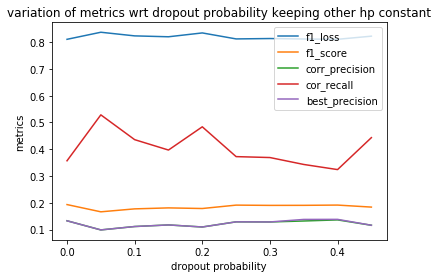

In [26]:
checkpoint = torch.load("/content/drive/My Drive/dropout_probability.pt")
METRICS_best_val_loss = checkpoint['metrics_best_val_loss']
METRICS_best_val_precision = checkpoint['metrics_best_val_precision']
dropout_p_list = checkpoint['dropout_p_list']
plt.plot(dropout_p_list, METRICS_best_val_loss[0], label='f1_loss')
plt.plot(dropout_p_list, METRICS_best_val_loss[1], label='f1_score')
plt.plot(dropout_p_list, METRICS_best_val_loss[2], label='corr_precision')
plt.plot(dropout_p_list, METRICS_best_val_loss[3], label='cor_recall')
plt.plot(dropout_p_list, METRICS_best_val_precision[0], label='best_precision')
plt.title('variation of metrics wrt dropout probability keeping other hp constant')
plt.xlabel('dropout probability')
plt.ylabel('metrics')
plt.legend()
plt.show()

In [29]:
max_f1_index = np.argmax(METRICS_best_val_loss[1])
dropout_p_max_f1 = dropout_p_list[max_f1_index]
max_f1 = METRICS_best_val_loss[1][max_f1_index]
corr_pr = METRICS_best_val_loss[2][max_f1_index]
corr_recall = METRICS_best_val_loss[3][max_f1_index]


print('value of dropout_p at which f1 score is max = ', dropout_p_max_f1, 'corr precision = ', corr_pr, 'corr_recall = ', corr_recall)

max_pr_index = np.argmax(METRICS_best_val_loss[2])
dropout_p_max_pr = dropout_p_list[max_pr_index]
max_pr = METRICS_best_val_loss[2][max_pr_index]
corr_recall = METRICS_best_val_loss[3][max_pr_index]
print('value of dropout_p at which precision is max = ', dropout_p_max_pr, 'max precision = ', max_pr, 'corr_recall = ',corr_recall)

value of dropout_p at which f1 score is max =  0.0 corr precision =  0.13291218876838684 corr_recall =  0.35697758197784424
value of dropout_p at which precision is max =  0.4 max precision =  0.13623271882534027 corr_recall =  0.3240794837474823
